In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.gray()

<Figure size 432x288 with 0 Axes>

In [20]:
path = 'images/sample_without_occclusion/rectified'

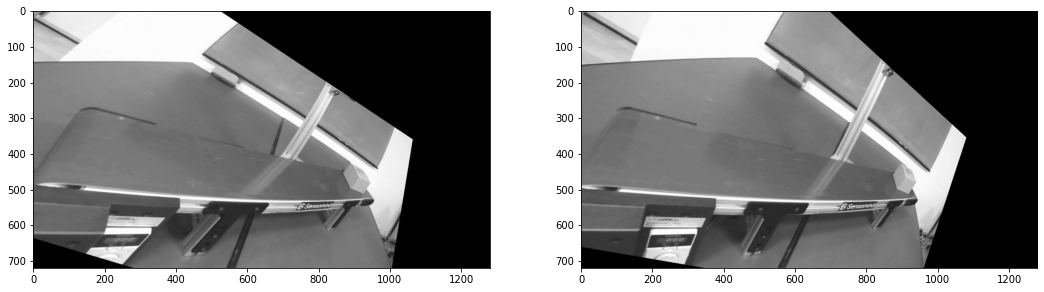

In [21]:
# load the images
img_left = cv2.imread(path+'/left/left-0.png')
img_right = cv2.imread(path+'/right/right-0.png')

# convert images to grayscale for template matching
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(gray_left)
ax_right.imshow(gray_right)

### 1 Sum of absolute differences

In [22]:
# # load the images
# matching = cv2.imread("nose_left.png")
# template = cv2.imread("nose_right.png")

# # convert images to grayscale for template matching
# gray_matching = cv2.cvtColor(matching, cv2.COLOR_BGR2GRAY)
# gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# f, (ax_left, ax_right) = plt.subplots(1, 2)
# ax_left.imshow(gray_matching)
# ax_right.imshow(gray_template)

In [23]:
def gray_SAD_matching(left, right, d=None):
    """
    Does the stuff
    """
    return np.sum(np.abs(left.astype(int)-right.astype(int)))

def for_SAD(left, right, verbose=False):
    """
    For loops baby
    """
    SAD = 0
    for row in range(len(left)):
        if verbose:
            print("[ ", end="")
        for col in range(len(left[row])):
            diff = np.abs(int(left[row][col]) - int(right[row][col]))
            SAD += diff
            if verbose:
                print(diff, end="\t")
        if verbose:
            print("]")
    return SAD


In [24]:
A = np.array([[10, 15, 20], [20, 20, 25], [10, 15, 20]])
B = np.array([[15, 15, 15], [20, 20, 20], [30, 30, 30]])
print(gray_SAD_matching(A, B))

60


In [25]:
# print(gray_SAD_matching(gray_matching, gray_template))
# print(for_SAD(gray_matching, gray_template))


In [26]:
# f, (ax_left, ax_right) = plt.subplots(1, 2)
# ax_left.imshow(gray_matching)
# ax_right.imshow(gray_template)

### 2 

In [27]:
# for i in range(3):
#     # load the images
#     matching = cv2.imread("nose_left.png")
#     template = cv2.imread("nose"+str(i+1)+".png")

#     # convert images to grayscale for template matching
#     gray_matching = cv2.cvtColor(matching, cv2.COLOR_BGR2GRAY)
#     gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

#     f, (ax_left, ax_middle, ax_right) = plt.subplots(1, 3)
#     ax_left.imshow(gray_matching, cmap=cm.gray)
#     ax_middle.imshow(np.abs(np.subtract(gray_matching.astype(int), gray_template.astype(int))))
#     ax_right.imshow(gray_template, cmap=cm.gray)
#     print("--------------------------")
#     print(i+1," => ", gray_SAD_matching(gray_matching, gray_template))
#     print(i+1," => ", for_SAD(gray_matching, gray_template))


The best match was found between nose2.png and nose_left

In [28]:
def one_line_scan(line, template):
    """
    """
    if len(template) != len(line):
        raise ValueError("Different heights")
    if len(template[0])%2 == 0:        
        raise ValueError("Odd number width required")
    min_loc = 0
    min_value = float("inf")

    for i in range(len(line[0])-len(template[0])):
        cut_out = line[:, i:i+(len(template[0]))]
        value = gray_SAD_matching(cut_out, template)
        if value < min_value:
            min_value = value
            min_loc = i
    return min_value, min_loc

In [29]:
# line = cv2.imread("nose_span.png")
# template = cv2.imread("nose2.png") # best nose

# # convert images to grayscale for template matching
# gray_line = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)
# gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# min_value, min_loc = one_line_scan(gray_line, gray_template)
# print(min_value, min_loc)

In [30]:
# top_left = min_loc
# nose = cv2.rectangle(line.copy(), (min_loc, 0), (min_loc+len(template[0]), len(template[0])), (255,0,0), 1)
# plt.figure(figsize=(12,12))
# plt.imshow(nose)

### CHALLENGE

In [31]:
def disparity(gray_left, gray_right, n=7):
    """
    
    """
    disparity_map = []

    for row in range(0, len(gray_left)-n, n):
        R = []
        for col in range(0, len(gray_left[0])-n, n):

            cut_out = gray_left[row:row+n, col:col+n]
            # Only need to scan to the left when looking with the right eye
            gray_line = gray_right[row:row+n, 0:col+n]
            _, min_loc = one_line_scan(gray_line, cut_out)

            R.append(abs(col - min_loc))
        disparity_map.append(R)
    
    disparity_map = np.asfarray(disparity_map)
    disparity_map *= 255.0/disparity_map.max()
    return disparity_map

In [32]:
d_map = np.asarray(disparity(gray_left, gray_right, n=9))

In [33]:
min_disp = 7 # 7
num_disp = 3*16 # 3*16
block_size = 9 # 5, 11
stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = block_size)
stereo.setMinDisparity(min_disp)
stereo.setDisp12MaxDiff(200) # 200
stereo.setUniquenessRatio(1) # 1
stereo.setSpeckleRange(10) # 3
stereo.setSpeckleWindowSize(1) # 3

disp = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

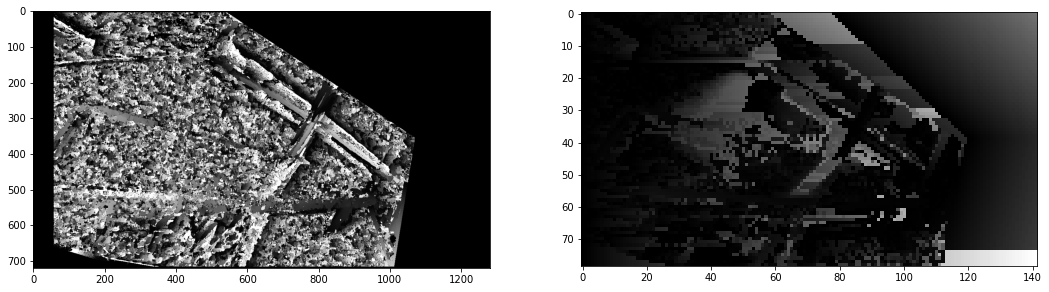

In [34]:
f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(disp)
ax_right.imshow(d_map)

### Improving on the results, in disparity_2()

In [35]:
def max_min_filter(img, K_size):
    height, width = img.shape
    pad = K_size // 2
    out_img = img.copy()
    pad_img = np.zeros((height + pad*2, width + pad*2), dtype=np.uint8)
    pad_img[pad: pad+height, pad: pad+width] = img.copy()
    for y in range(height):
        for x in range(width):
            out_img[y,x] = np.max(pad_img[y:y+K_size, x:x+K_size]) - np.min(pad_img[y:y+K_size, x:x+K_size])
    return out_img

In [36]:
def disparity_2(gray_left, gray_right, n=7, max_disp=float("inf"), min_disp=0):
    """
    
    """
    disparity_map = np.zeros(shape=((len(gray_left)-n)//n +1, (len(gray_left[0])-n)//n +1)).astype(float)
    
    index_1 = 0
    index_2 = 0
    for row in range(0, len(gray_left)-n, n):
        R = []
        for col in range(0, len(gray_left[0])-n, n):

            cut_out = gray_left[row:row+n, col:col+n]
            # Only need to scan to the left when looking with the right eye
            gray_line = gray_right[row:row+n, 0:col+n]
            _, min_loc = one_line_scan(gray_line, cut_out)

            disp = np.abs((col - min_loc), dtype=float)
            
            if disp>max_disp or disp<min_disp:
                if index_1>0 and index_2>0:
                    disp = np.mean(disparity_map[index_2-1:index_2+1, index_1-1:index_1+1])
                else:
                    disp = np.mean(disparity_map)


            disparity_map[index_2][index_1] = disp
            index_1 +=1

        index_2 +=1
        index_1 = 0
    
    disparity_map *= 255.0/disparity_map.max()

    return np.float32(disparity_map)

In [37]:
d_map_3 = disparity_2(gray_left, gray_right, n=9, max_disp=60, min_disp=10)

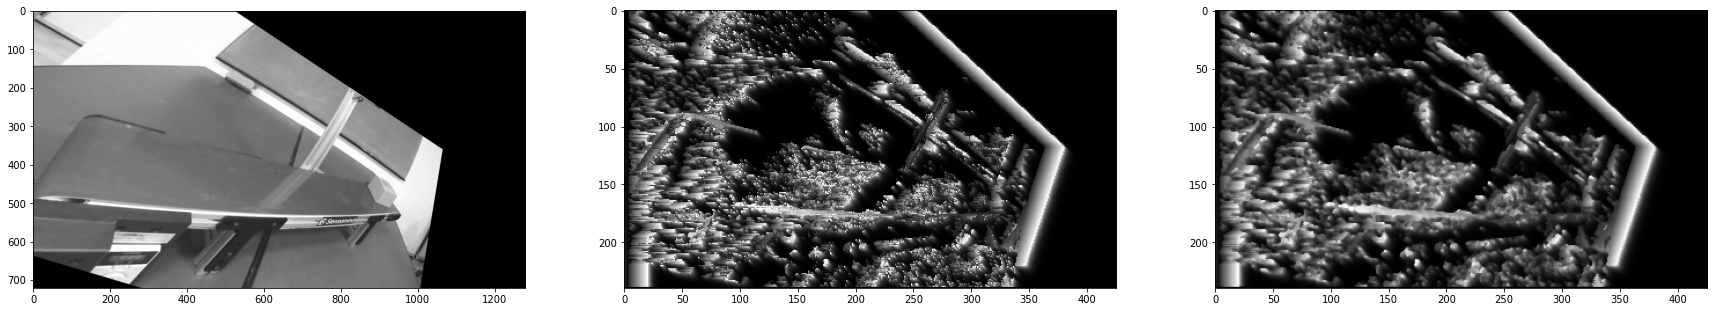

In [38]:
f, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(30,30))
ax_1.imshow(gray_left)
ax_2.imshow(d_map_3)
ax_3.imshow(cv2.medianBlur(d_map_3, 3))

In [39]:
# Apply additional filter on d_map
blurred = cv2.GaussianBlur(d_map_3, (3, 3), 0)
filtered = cv2.medianBlur(d_map_3, 3)
maxed = max_min_filter(d_map_3, 3)

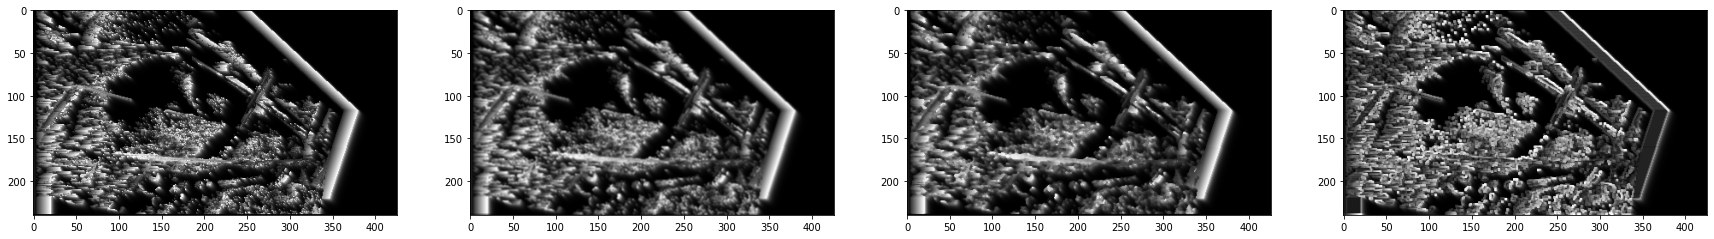

In [40]:
f, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(1, 4, figsize=(30,30))
ax_1.imshow(d_map_3)
ax_2.imshow(blurred)
ax_3.imshow(filtered)
ax_4.imshow(maxed)

### What about n=1?

In [41]:
d_map = disparity_2(gray_left, gray_right, n=1, max_disp=60, min_disp=10)
f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(gray_left)
ax_right.imshow(d_map)